# Porting PyTorch to ONNX to OpenVINO

## Packages

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import onnx
import onnxruntime
from openvino.inference_engine import IENetwork, IEPlugin
from matplotlib import pyplot as plt

This notebook is checked with
- PyTorch 1.0.1 + torchvision 0.2.0
- PyTorch 1.1.0 + torchvision 0.3.0

In [2]:
! pip list | grep torch

torch              1.1.0   
torchvision        0.3.0   


ONNX 1.5.0 and ONNXruntime 0.4.0 is suggested

In [3]:
! pip list | grep onnx

onnx               1.5.0   
onnxruntime        0.4.0   


## Instanciate a pretrained PyTorch model

In [4]:
model_name = 'inception_v4'

# model instance
if model_name == 'inception_v3':
    model = models.inception_v3(pretrained=True, transform_input=False)
elif model_name == 'inception_v4':
    from model_zoo.inceptionv4 import inceptionv4
    model = inceptionv4(pretrained='imagenet')
elif model_name == 'resnet50':
    model = models.resnet50(pretrained=True)
elif model_name == 'resnext50_32x4d':
    model = models.resnext50_32x4d(pretrained=True)
elif model_name == 'squeezenet1_0':
    model = models.squeezenet1_0(pretrained=True)
elif model_name == 'mobilenet_v2':
    from model_zoo.mobilenet import mobilenet_v2
    model = mobilenet_v2(pretrained=True)
elif model_name == 'shufflenet_v2_x1_0':
    from model_zoo.shufflenetv2 import shufflenet_v2_x1_0
    model = shufflenet_v2_x1_0(pretrained=True)
elif model_name == 'nasnet_a_large':
    from model_zoo.nasnet import nasnetalarge
    model = nasnetalarge(num_classes=1000, pretrained='imagenet')
else:
    raise ValueError('invalid model')

# apply cuda
if torch.cuda.is_available():
    model = model.cuda()

# evaluation mode
model = model.eval()

## Input transformation for PyTorch

In [5]:
# norm_mean and norm_std defined as RGB
if model_name == 'inception_v3' or 'inception_v4':
    target_size = 299
    norm_mean = [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
elif model_name == 'nasnet_a_large':
    target_size = 331
    norm_mean = [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
else:
    target_size = 224
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

# transformation
trans = transforms.Compose([
    transforms.Resize(int(target_size/224*256)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

## Introduce the label map from ImageNet

In [6]:
from imagenet_labels import labelmap
print(list(labelmap.values())[:10])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus']


## Read in the input image

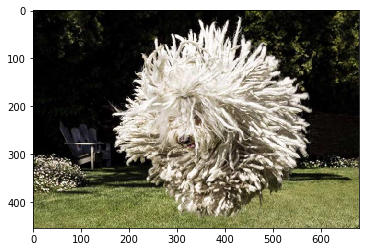

In [7]:
image = Image.open('dog-komodor.jpg')
plt.imshow(image)

## PyTorch inference

In [8]:
# apply transformation
image_tensor = trans(image)
# extend batch dimension
image_tensor = image_tensor.unsqueeze(dim=0)
# apply cuda
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()

logits = model(image_tensor)

In [9]:
k = 10
values, indices = torch.topk(logits, k)
for i in range(k):
    print(values[0][i].item(), labelmap[indices[0][i].item()])

10.139122009277344 komondor
3.1586945056915283 kuvasz
2.6030259132385254 kelpie
2.281796455383301 space bar
2.2293763160705566 printer
1.8176441192626953 Old English sheepdog, bobtail
1.8124595880508423 cardoon
1.7151975631713867 standard poodle
1.6284362077713013 otterhound, otter hound
1.5693174600601196 Irish water spaniel


## Porting to ONNX
Save the processed image tensor as numpy array

In [10]:
print('image tensor shape = ', image_tensor.shape)
print('top left patch (green channel) = ', image_tensor[0,1,:2,:2])
np.savez('test_input.npz', image_tensor.cpu())

# test if it can be loaded correctly
image_file = np.load('test_input.npz')
image_np = image_file['arr_0']
image_file.close()
print('image numpy array shape = ', image_np.shape)
print('top left patch (green channel) = ', image_np[0,1,:2,:2])

image tensor shape =  torch.Size([1, 3, 299, 299])
top left patch (green channel) =  tensor([[-0.9216, -0.9529],
        [-0.8353, -0.9608]], device='cuda:0')
image numpy array shape =  (1, 3, 299, 299)
top left patch (green channel) =  [[-0.92156863 -0.9529412 ]
 [-0.8352941  -0.9607843 ]]


Convert the model to ONNX

In [11]:
onnx_file = 'model_{}.onnx'.format(model_name)
os.environ['ONNX_FILE'] = onnx_file

# export the model
torch.onnx._export(model, image_tensor, onnx_file, export_params=True, verbose=True)
# print model information
model_onnx = onnx.load(onnx_file)
onnx.checker.check_model(model_onnx) # will print nothing if nothing wrong

/home/minan/workspace/openvino_porting/model_zoo/inceptionv4.py:308: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  adaptiveAvgPoolWidth = int(features.shape[2])


graph(%0 : Float(1, 3, 299, 299),
      %1 : Float(32, 3, 3, 3),
      %2 : Float(32),
      %3 : Float(32),
      %4 : Float(32),
      %5 : Float(32),
      %6 : Long(),
      %7 : Float(32, 32, 3, 3),
      %8 : Float(32),
      %9 : Float(32),
      %10 : Float(32),
      %11 : Float(32),
      %12 : Long(),
      %13 : Float(64, 32, 3, 3),
      %14 : Float(64),
      %15 : Float(64),
      %16 : Float(64),
      %17 : Float(64),
      %18 : Long(),
      %19 : Float(96, 64, 3, 3),
      %20 : Float(96),
      %21 : Float(96),
      %22 : Float(96),
      %23 : Float(96),
      %24 : Long(),
      %25 : Float(64, 160, 1, 1),
      %26 : Float(64),
      %27 : Float(64),
      %28 : Float(64),
      %29 : Float(64),
      %30 : Long(),
      %31 : Float(96, 64, 3, 3),
      %32 : Float(96),
      %33 : Float(96),
      %34 : Float(96),
      %35 : Float(96),
      %36 : Long(),
      %37 : Float(64, 160, 1, 1),
      %38 : Float(64),
      %39 : Float(64),
      %40 : Float(64),
  

Test running on ONNX model

In [12]:
onnx_session = onnxruntime.InferenceSession(onnx_file)
input_blob = onnx_session.get_inputs()[0].name
output_blob = onnx_session.get_outputs()[0].name
res = onnx_session.run([output_blob], {input_blob: image_np})
logits = res[0].squeeze()

In [13]:
k = 10
indices = logits.argsort()[::-1][:k]
for i in indices:
    print(logits[i], labelmap[i])

10.13912 komondor
3.158694 kuvasz
2.6030257 kelpie
2.2817965 space bar
2.2293763 printer
1.8176438 Old English sheepdog, bobtail
1.8124592 cardoon
1.7151973 standard poodle
1.6284359 otterhound, otter hound
1.569317 Irish water spaniel


## Convert to OpenVINO IR

Making sure the OpenVINO path is set to `$PYTHONPATH`

In [14]:
! echo $PYTHONPATH | grep openvino

/home/minan/workspace/caffe/external/mlsl/l_mlsl_2018.1.005/intel64/include:/home/minan/workspace/caffe/python:/opt/intel/openvino_2019.1.094/python/python3.7:/opt/intel/openvino_2019.1.094/deployment_tools/model_optimizer:


Run model converter

In [15]:
! python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model $ONNX_FILE

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/minan/workspace/openvino_porting/model_inception_v4.onnx
	- Path for generated IR: 	/home/minan/workspace/openvino_porting/.
	- IR output name: 	model_inception_v4
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2019.1.0-341-gc9b66a2

[ SUCCESS ] Generated IR model.
[ SUCCESS ] XML file: /home/minan/workspace/openvino_porting/./model_inception_v4.xml
[ SUCCESS ] BIN file: /home/minan/workspa

## Run OpenVINO inference

Now we have `*.xml` and `*.bin` files for inferencing

In [16]:
def load_openvino_model(device, model_xml, model_bin):
    plugin = IEPlugin(device=device, plugin_dirs=None)
    net = IENetwork(model=model_xml, weights=model_bin)
    supported_layers = plugin.get_supported_layers(net)
    not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
    if len(not_supported_layers) != 0:
        print("Following layers are not supported by the plugin for specified device {}:\n {}".format(plugin.device, ', '.join(not_supported_layers)))
    else:
        print("All layers supported")
    exec_net = plugin.load(network=net)
    input_blob = next(iter(net.inputs))
    output_blob = next(iter(net.outputs))
    return plugin, exec_net, input_blob, output_blob

In [17]:
# load model
xml_file = 'model_{}.xml'.format(model_name)
bin_file = 'model_{}.bin'.format(model_name)
plugin, exec_net, input_blob, output_blob = load_openvino_model('CPU', xml_file, bin_file)

All layers supported


In [18]:
# run inference
res = exec_net.infer(inputs={input_blob: image_np})
logits = res[output_blob].squeeze()

In [19]:
k = 10
indices = logits.argsort()[::-1][:k]
for i in indices:
    print(logits[i], labelmap[i])

10.139121 komondor
3.158694 kuvasz
2.6030257 kelpie
2.2817965 space bar
2.2293768 printer
1.8176436 Old English sheepdog, bobtail
1.8124592 cardoon
1.7151976 standard poodle
1.6284359 otterhound, otter hound
1.5693177 Irish water spaniel
